In [364]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

In [365]:
#Load in data and split for train and test sets
df = pd.read_csv(r'C:\Users\jackc\Semester2\Project\Identifying-Hate-Speech-Categories-On-Social-Media\Data\clean_dataset.csv')
df.head(5)

,id,text,Annotation,tokenized_text,text_lemma,pos_tags,Hate
0,5.969655e+17,i just found the perfect rental why cant my le...,Neither,"['found', 'perfect', 'rental', 'cant', 'lease'...","['found', 'perfect', 'rental', 'cant', 'lease'...","['i_NN', 'just_RB', 'found_VBD', 'the_DT', 'pe...",0
1,5.758918e+17,every time they discover anything its either ...,Neither,"['every', 'time', 'discover', 'anything', 'eit...","['every', 'time', 'discover', 'anything', 'eit...","['every_DT', 'time_NN', 'they_PRP', 'discover_...",0
2,5.952595e+17,ok time to write code bbl\n\nmaking a new thing,Neither,"['ok', 'time', 'write', 'code', 'bbl', 'making...","['ok', 'time', 'write', 'code', 'bbl', 'making...","['ok_JJ', 'time_NN', 'to_TO', 'write_VB', 'cod...",0
3,5.723449e+17,refined dessert not mkr,Neither,"['refined', 'dessert', 'mkr']","['refined', 'dessert', 'mkr']","['refined_VBN', 'dessert_NN', 'not_RB', 'mkr_VB']",0
4,5.681320e+17,one of the best things anyone can do to impr...,Neither,"['one', 'best', 'things', 'anyone', 'improve',...","['one', 'best', 'thing', 'anyone', 'improve', ...","['one_CD', 'of_IN', 'the_DT', 'best_JJS', 'thi...",0


In [366]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot

vocab_size = len(df['text'])
one_hot_enc = []
for sent in df['text']:
    one_hot_enc.append(one_hot(sent, vocab_size))

df['one_hot_enc'] = one_hot_enc

df.head(5)

,id,text,Annotation,tokenized_text,text_lemma,pos_tags,Hate,one_hot_enc
0,5.969655e+17,i just found the perfect rental why cant my le...,Neither,"['found', 'perfect', 'rental', 'cant', 'lease'...","['found', 'perfect', 'rental', 'cant', 'lease'...","['i_NN', 'just_RB', 'found_VBD', 'the_DT', 'pe...",0,"[5688, 5895, 2370, 941, 4196, 2187, 5913, 4885..."
1,5.758918e+17,every time they discover anything its either ...,Neither,"['every', 'time', 'discover', 'anything', 'eit...","['every', 'time', 'discover', 'anything', 'eit...","['every_DT', 'time_NN', 'they_PRP', 'discover_...",0,"[3737, 809, 3495, 5185, 2164, 5678, 6567, 5062..."
2,5.952595e+17,ok time to write code bbl\n\nmaking a new thing,Neither,"['ok', 'time', 'write', 'code', 'bbl', 'making...","['ok', 'time', 'write', 'code', 'bbl', 'making...","['ok_JJ', 'time_NN', 'to_TO', 'write_VB', 'cod...",0,"[6833, 809, 1274, 3108, 4882, 2037, 4604, 2160..."
3,5.723449e+17,refined dessert not mkr,Neither,"['refined', 'dessert', 'mkr']","['refined', 'dessert', 'mkr']","['refined_VBN', 'dessert_NN', 'not_RB', 'mkr_VB']",0,"[4281, 3350, 4640, 2557]"
4,5.681320e+17,one of the best things anyone can do to impr...,Neither,"['one', 'best', 'things', 'anyone', 'improve',...","['one', 'best', 'thing', 'anyone', 'improve', ...","['one_CD', 'of_IN', 'the_DT', 'best_JJS', 'thi...",0,"[3611, 6209, 941, 61, 742, 6438, 1331, 5133, 1..."


In [367]:
X_train, X_test, y_train, y_test = train_test_split(df['one_hot_enc'], df['Hate'], test_size=0.25, 
                                                    random_state=12)

MAX_LENGTH = 200
padded_train_data = pad_sequences(X_train, MAX_LENGTH, padding='pre', truncating='pre')
padded_test_data = pad_sequences(X_test, MAX_LENGTH, padding='pre', truncating='pre')

padded_train_data

array([[   0,    0,    0, ...,    0,    0, 2063],
       [   0,    0,    0, ..., 5007, 2160, 2476],
       [   0,    0,    0, ..., 4929, 3621,  579],
       ...,
       [   0,    0,    0, ..., 5688, 3065,  344],
       [   0,    0,    0, ..., 1274, 3809, 2369],
       [   0,    0,    0, ..., 6080, 5471, 1453]])

In [414]:
from keras.layers import Input, Embedding, Dense, LSTM, GlobalAveragePooling1D
from keras.models import Model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


EMBED_SIZE = 100

# # #first step
# inputs = Input((200,), dtype='int32')

# # #second step
# embedding = Embedding(vocab_size, EMBED_SIZE, name='embed_layer', 
#                       embeddings_initializer='glorot_uniform', mask_zero=True)(inputs)
# # #third step
# ltsm = LSTM(100)(embedding)

# # #final layer
# outputs = Dense(1,activation='sigmoid',input_shape=(1,))(ltsm)

# # #compile
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f1_m])

BOW_pretrained = Sequential()
BOW_pretrained.add(Input((200,), dtype='int32'))
#embedding
BOW_pretrained.add(Embedding(vocab_size, EMBED_SIZE, name='embed_layer', 
                      embeddings_initializer='glorot_uniform', mask_zero=True))

#unweighted average of word vectors
BOW_pretrained.add(GlobalAveragePooling1D())
#hidden layer
BOW_pretrained.add(Dense(16, activation='relu'))
#output sigmoid
BOW_pretrained.add(Dense(1, activation='sigmoid'))
BOW_pretrained.summary()

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f1_m])
# YOUR CODE GOES HERE


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed_layer (Embedding)      (None, 200, 100)          683600    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 17        
Total params: 685,233
Trainable params: 685,233
Non-trainable params: 0
_________________________________________________________________


In [415]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embed_layer (Embedding)      (None, 200, 100)          683600    
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 101       
Total params: 764,101
Trainable params: 764,101
Non-trainable params: 0
_________________________________________________________________


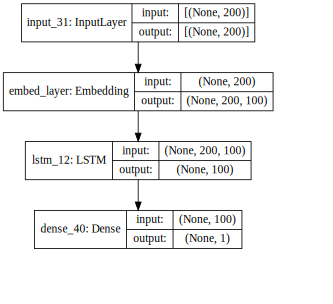

In [416]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


In [ ]:
cw = {0: 1., 1: 100.}

history = model.fit(padded_train_data, y_train, epochs=3, batch_size=256, class_weight=cw)

Epoch 1/3
15/21 [====================>.........] - ETA: 5s - loss: 3.2878 - f1_m: 0.2936

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results =  model.evaluate(padded_test_data, y_test)
print('test_loss:', results[0], 'test_accuracy:', results[1])

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(padded_test_data)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))
print(f1_score(y_test, y_pred , average="macro"))

In [ ]:
import sklearn

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))

confusion_matrix

In [ ]:
# your code goes here
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history.history, path="standard.png")
plt.show()
